In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [2]:
import os
import sys

import math
import numpy as np
import requests
import ipywidgets as widgets
import matplotlib.pyplot as plt
from IPython.display import display, display_markdown
from ipywidgets import Layout, HTML
from pathlib import Path
import time


NGL_DEF = False
try:
    import nglview as nv
    NGL_DEF = True
except:
    NGL_DEF = False
    

import parmed as pmd
import re

from scipy.ndimage import gaussian_filter

np.set_printoptions(precision=8)
np.set_printoptions(suppress=True)


HTMLButtonPrompt = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<a href="{link}" target="_blank" >
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="width:100px; background-color:#E9E9E9; font-size:10pt; color:black">{text}</button>
</a>
</body>
</html>
'''

HTMLDeadPrompt = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="width:100px; background-color:#E9E9E9; font-size:10pt; color:#D2D2D2">{text}</button>
</body>
</html>
'''

SelDirPrompt = '''<html>
<head>
<meta name="viewport" content="width=device-width, initial-scale=1">
</head>
<body>
<a href="{link}" target="_blank" >
<button class="p-Widget jupyter-widgets jupyter-button widget-button mod-warning" style="text-align: start; width:400px; height:40px; border-style: solid; border-color: black; border-width: thin; background-color:#E9E9E9; font-size:12pt; color:black">{text}</button>
</a>
</body>
</html>
'''

forbidden_strings = ["..", "/", "\\", " ", "~"]

In [3]:
sys.path.append('./main/')

import pigment
import tresp
import pdc
import nsd
import phutil

# Set data storage directory
try:
    DATADIR = os.path.relpath(os.environ['DATADIR'])
except:
    DATADIR = './data'
    phutil.build_data_folders(DATADIR)

In [4]:
# These names are considered essential to all Chl/BChl molecules
# Without these, we can do no calculations. 
ChlBaseNames = []
for ring in ['A', 'B', 'C', 'D']:
    for at in ['N', 'C1', 'C2', 'C3', 'C4', 'CH']:
        ChlBaseNames.append(at+ring)
ChlBaseNames.append('CAD')
ChlBaseNames.append('CBD')

# These are the atoms of the phytol tail
PhytolNames = []
for n in range(1, 21):
    PhytolNames.append('C'+str(n))
    
# These atoms are 
ChlOptNames = ['CAA', 'CBA', 'CGA', 'O1A', 'O2A', 'CMA', 'CMB', 'CAB', 'CMC', 'CAC', 'CBC', 'CMD', 'OBD'] + PhytolNames

# The tetpy class describes common tetrapyrrole pigments
tetpy = pigment.category('tetrapyrrole', ChlBaseNames)


# These atoms can be used to distinguish between different pigment types
# Note: 
#    The heavy atoms of Chl a, Chl c1, Chl c2, and BChl g are identical (excluding the phytol tail)
#    The heavy atoms of BChl a and BChl b are identical
CLANames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED'] + ChlOptNames
CLBNames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED', 'OMC']  + ChlOptNames
CLDNames = ['MG',        'CGD', 'O1D', 'O2D', 'CED',        'OBB'] + ChlOptNames
CLFNames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED',               'OMB']  + ChlOptNames
BCANames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED',        'OBB'] + ChlOptNames
BCBNames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED',        'OBB'] + ChlOptNames
BCCNames = ['MG', 'CBB',                                    'OBB',        'CIB'] + ChlOptNames
BCDNames = ['MG', 'CBB',                                    'OBB',               'CND'] + ChlOptNames
BCENames = ['MG', 'CBB',                             'OMC', 'OBB',        'CIB', 'CND'] + ChlOptNames
BCFNames = ['MG', 'CBB',                             'OMC', 'OBB',               'CND'] + ChlOptNames
BCGNames = ['MG', 'CBB', 'CGD', 'O1D', 'O2D', 'CED'] + ChlOptNames

# The corresponding Pheo names are the same, excluding the first entry (MG)
PHANames = CLANames[1:]
PHBNames = CLBNames[1:]
BPANames = BCANames[1:]

CLA = pigment.species(
    'Chl a',
    'CLA',
    tetpy,
    CLANames,
    4.3e-18 # statC*cm
)

CLB = pigment.species(
    'Chl b',
    'CLB',
    tetpy,
    CLBNames, 
    3.58e-18
)
# Updated CLB dipole strength from 3.6 to match same scaling as CLA compared
# to Knox & Spring calculated values. 

CLD = pigment.species(
    'Chl d',
    'CLD',
    tetpy,
    CLDNames, 
    0.0
)

CLF = pigment.species(
    'Chl f',
    'CLF',
    tetpy,
    CLFNames,
    0.0
)

BCA = pigment.species(
    'BChl a',
    'BCA',
    tetpy,
    BCANames, 
    5.45e-18
)
# Changed BCA dipole strength to 5.45 instead of 5.47 on 11/7/2023 -- MER
# This matches the Knox & Springer oscillator strength scaled by 0.8 as per
# Adolphs & Renger. 

BCB = pigment.species(
    'BChl b',
    'BCB',
    tetpy,
    BCBNames, 
    0.0
)

BCC = pigment.species(
    'BChl c',
    'BCC',
    tetpy,
    BCCNames,
    0.0
)

BCD = pigment.species(
    'BChl d',
    'BCD',
    tetpy,
    BCDNames, 
    0.0
)

BCE = pigment.species(
    'BChl e',
    'BCE',
    tetpy,
    BCENames, 
    0.0
)

BCF = pigment.species(
    'BChl f',
    'BCF',
    tetpy,
    BCFNames, 
    0.0
)

BCG = pigment.species(
    'BChl g',
    'BCG',
    tetpy,
    BCGNames, 
    0.0
)

PHA = pigment.species(
    'Pheo a',
    'PHA',
    tetpy,
    PHANames,
    3.50e-18
)

UNK = pigment.species(
    'Unknown',
    'UNK',
    tetpy,
    [],
    0.0
)


# We put pheophytins first. This way, pigments are assigned to Pheos
# if an MG is not present. (Otherwise, algorithm may default to Chl,
# imagining that MG may just be missing from the structure.)
TetPyList = [
    PHA, 
    CLA, CLB, #CLD, CLF, 
    BCA, #BCB, BCC, BCD, BCE, BCF, BCG,
]

In [5]:
HintList = [
    "Double click on the structure viewer to enter full-screen mode. Pres <esc> key to exit.",
    "For CDC (electrostatic) site-energy shift calculations, first build an MD Model and then load the MD run from the main menu.",
    "The <a href=\"repair.ipynb\" target=\"_blank\">Structure Repair tool</a> can both fill in missing pigment atoms and perform symmetry operations to build PDB-assigned biological functional units."
]

In [20]:
# Global variables:

# Main ParmEd structure
struc = pmd.structure.Structure()

# File name frm which struc was loaded
struc_fname = ''

# Representation list for main structure
mainreps = list()

# Representation list for dipoles
dipreps = list()

# List of chains in struc
ChainList = []

# List of identified pigments
PigList = []

##################################################################
# Main frame layout:
##################################################################

# mainbox is the top widget. It contains:
#  pdbview -- an NGLWidget used to display the loaded structures
#  mainacc -- an accordion widget containing the following VBoxes:
#    strucbox -- contains the "Load" interface
#    selbox -- contains the "Select" interface
#    writebox -- contains the "Write PDB" interface
#    repair -- repairs problems with chl pigments and/or protein symmetry
#    excbox -- contains the "Prepare Exciton Model" interface
#    mdbox -- contains the "Prepare MD Model" interface

# Structure viewer:
if NGL_DEF:
    pdbview = nv.NGLWidget()
    pdbview._set_size('500px', '500px')
    pdbview.camera = 'orthographic'
else:
    pdbview = widgets.HTML(value='<p style=\"text-align:center; font-size:20px\"><br><br>Install NGLView library<br>to view structures.</p>', 
                          layout=widgets.Layout(width='500px', height='500px'))


##################################################################
# strucbox: Interface for loading molecular structures
##################################################################

# pdbid: Text entry box for PDB ID 
# pdbidlbl: Label for pdbid
# pdbfetch: Button to fetch PDB from the RCSB databank
# pdbup: Button to upload PDB file
# pdbuplbl: Label for pdbup


pdbid = widgets.Text(
    value='2DRE',
    placeholder='',
    layout = widgets.Layout(width='1.5cm'),
    disabled=False
)


pdbidlbl = widgets.Label(value='PDB ID:', layout=Layout(width='1.5cm'))

pdbfetch = widgets.Button(
    description='Fetch',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to display the pdb file',
    layout = widgets.Layout(width='3.75cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)

pdbup = widgets.FileUpload(
    accept='.cif, .pdb, .gro',  # Accepted file extension e.g. '.txt', '.pdf', 'image/*', 'image/*,.pdf'
    multiple=False,  # True to accept multiple files upload else False
    layout=Layout(width='5cm')
)

pdbuplbl = widgets.Label(value='Upload file:', layout=Layout(width='1.9cm'))

def strip_protein(fname):
    # First, check if any HETAMs are located
    checktxt = !{"grep ^HETATM " + fname + " | head -n 1"}

    # If so, keep *only* HETATM entries:
    if len(checktxt)>0:
        out = !{"grep ^HETATM " + fname + " > " + DATADIR + "/pdb/tmp.cif"}
        out = !{"cp " + DATADIR + "/pdb/tmp.cif " + fname}

    # Otherwise, load the full structure
    else:
        setmsg('No HETATMs found: loading full structure, including protein.')
        protCheck.value = False

# Executed with pdbfetch is clicked
def pdbfetch_onclick(b):

    url = 'http://files.rcsb.org/download/' + pdbid.value + '.cif'
    r = requests.get(url, allow_redirects=True)
    if(r.status_code!=200):
        setmsg('Invalid PDB code. Please try again.')
    else:
        fname = DATADIR + '/pdb/'+pdbid.value+'.cif'
        wfd = open(fname, 'wb')
        wfd.write(r.content)
        wfd.close()
        
        # If "ignore protein" is checked, keep only HETATM entries
        if protCheck.value==True:
            strip_protein(fname)
        
        init_struc(fname)
pdbid.on_submit(pdbfetch_onclick)

# Executed when pdbup is clicked
def pdbup_on_value_change(change):
    
    for item in pdbup.value:
            fname = item
        
    with open(DATADIR + "/pdb/"+fname, "wb") as fp:
        fp.write(pdbup.value[fname]["content"])
    fp.close()
    
    # If "ignore protein" is checked, keep only HETATM entries
    if protCheck.value==True:
        strip_protein(fname)
    
    init_struc(DATADIR + "/pdb/"+fname)
    
#     out = !{'ls ' + DATADIR + '/pdb/'}
#     for line in out:
#         print(line)
    
#     if os.path.isfile(DATADIR + '/pdb/' + fname):
#         print('Using stored local structure')
#         init_struc(DATADIR + "/pdb/"+fname)
#     else:
#         with open(DATADIR + "/pdb/"+fname, "wb") as fp:
#             fp.write(pdbup.value[fname]["content"])
#         fp.close()
#         init_struc(DATADIR + "/pdb/"+fname)
        
        
pdbup.observe(pdbup_on_value_change, 'value')


locdrop = widgets.Dropdown(
    options=[],
    value = None,
    description='Stored:',
    disabled=False,
    layout=Layout(width='3.75cm')
)
locdrop.style.description_width='1.15cm'


def locload_onclick(b):
    # If "ignore protein" is checked, keep only HETATM entries
#     if protCheck.value==True:
#         strip_protein(fname)
    fname = locdrop.value
    if len(fname)>0:
        init_struc(DATADIR + "/pdb/"+fname + ".pdb")

    
locload = widgets.Button(
    description='Load',
    disabled=False,
    tooltip='Click to load local file.',
    layout = widgets.Layout(width='1.3cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)
locload.on_click(locload_onclick)

locrefresh = widgets.Button(
    description='Refresh',
    disabled=False,
    tooltip='Click to refresh the local file list.',
    layout = widgets.Layout(width='1.75cm'),
    icon='' # (FontAwesome names without the `fa-` prefix)
)
def refresh_loclist(b):
    loc = locdrop.value
    flist = !{"ls " + DATADIR + "/pdb/*.pdb"}
    loclist = []
    for file in flist:
        prefix = file.split('/')[-1].split('.')[0]
        loclist.append(prefix)
    locdrop.options = loclist
locrefresh.on_click(refresh_loclist)



def locdrop_on_value_change(change):
    refresh_loclist(0)
locdrop.observe(locdrop_on_value_change)#, 'value')
refresh_loclist(0)


rundrop = widgets.Dropdown(
    options=['pdb2gmx', 'em', 'nvt'],
    value = 'pdb2gmx',
    description='MD:',
    disabled=False,
    layout=Layout(width='3.35cm')
)
rundrop.style.description_width='0.65cm'
def rundrop_on_value_change(change):
    refresh_grolist(0)
rundrop.observe(rundrop_on_value_change, 'value')

grodrop = widgets.Dropdown(
    options=[],
    value = None,
    description='run:',
    disabled=False,
    layout=Layout(width='4.25cm')
)
grodrop.style.description_width='0.6cm'

def refresh_grolist(b):
    run = rundrop.value
    flist = !{"ls " + DATADIR + "/md/*/"+run+"/"+run+".pdb"}
    grolist = []
    for file in flist:
        prefix = file.split('/')[-3]
        grolist.append(prefix)
    grodrop.options = grolist
    
# Executed when groload is clicked
def groload_onclick(b):
    
    if protCheck.value==True:
        setmsg("Sorry, exclude protein is not available for MD runs")
        
    prefix = grodrop.value
    if prefix!=None and prefix!='*' and len(prefix)>0:
        run = rundrop.value
        if run=='nvt':
            fname = DATADIR + "/md/"+prefix+"/"+run+"/traj.pdb"
        else:
            fname = DATADIR + "/md/"+prefix+"/"+run+"/"+run+".pdb"
        init_struc(fname)
        add_charges(DATADIR + "/md/"+prefix+"/"+run+"/charges.txt")
    
def add_charges(fname):
    global struc
    charges = np.loadtxt(fname)
    if len(charges)==len(struc.atoms):
        for n in range(0, len(struc.atoms)):
            atom = struc.atoms[n]
            atom.charge = charges[n]
            opts = list(siteselect.options)
            if opts.count('CDC')==0:
                opts.append('CDC')
                siteselect.options = opts
    else:
        setmsg('Error loading charges from file ' + fname)
        setmsg('Number of charges did not match the number of atoms in structure.')
        opts = list(siteselect.options)
        if opts.count('CDC'):
            opts.remove('CDC')
        siteselect.options = opts
        return -1
    
gro_refresh = widgets.Button(description='Refresh List')
gro_refresh.on_click(refresh_grolist)
refresh_grolist(0)

gro_load = widgets.Button(description='Load')
gro_load.on_click(groload_onclick)


protCheck = widgets.Checkbox(
    value=False,
    description='Ignore protein',
    disabled=False,
    indent=False,
    layout=Layout(width='3cm')
)



strucbox = widgets.VBox([
    widgets.HTML(value='<p style="line-height: 1.1">Load structures using one of the options below:</p>'),
    widgets.HBox([pdbidlbl, pdbid, pdbfetch]), 
#     protCheck,
    widgets.HBox([pdbuplbl, pdbup]),
    widgets.HBox([locdrop, locload, locrefresh]),
    widgets.VBox([widgets.HBox([rundrop, grodrop]),widgets.HBox([gro_load, gro_refresh])])
], layout=Layout(height='6cm', justify_content='space-between'))

# For now the displayed dipole structure is completely
# independent of the classified pigments. 
def build_dipstruc(struc):
    
    dipstruc = pmd.structure.Structure()
    
    dipcoords = []
    porphlist = list()
    porphtxt = '('
    PorphAts = ['NA', 'NB', 'NC', 'ND']
    for res in struc.residues:

        # Check if it's a porphyrrin
        foundNs = np.zeros((len(PorphAts),))
        patnums = np.zeros((len(PorphAts),), dtype='int')
        for at in res:
            for n in range(0, len(PorphAts)):
                if at.name==PorphAts[n]:
                    foundNs[n] = 1
                    patnums[n] = at.idx
        
        # If we located all four ring N atoms
        if np.sum(foundNs)==4:
            cenvec = 0.5*(struc.coordinates[patnums[1]] + struc.coordinates[patnums[3]])
            dipvec = (struc.coordinates[patnums[3]] - struc.coordinates[patnums[1]])
            vStart = cenvec - 1.25*dipvec
            vStop = cenvec + 1.25*dipvec
            Nats = 10
            for a in range(0, Nats+1):
                xyz = (float(a)/float(Nats))*vStart + (1 - float(a)/float(Nats))*vStop
                dipstruc.add_atom(pmd.topologyobjects.Atom(name='N'), 'Dip', res.idx, chain=res.chain)
                dipcoords.append(xyz)

            porphlist.append(res.idx)
            if len(porphtxt)>1:
                porphtxt += ' OR '
            porphtxt += str(res.idx+1)
    porphtxt += ')'

    # If any porphyrrins have been located, add the coordinates to the dipole list. 
    if len(dipcoords)>0:
        dipstruc.coordinates = np.array(dipcoords)
    else: 
        porphtxt = ""
        
    return dipstruc, porphtxt
    

# init_struc() loads a structure from the provided file name
# and initializes the structure view representations and chainlists
#
# Outside references:
#   sets pigbox.children and chainbox.children each time a new structure is loaded
#
# Relies on environment variables:
#   UNK
#   tetpy
#   TetPyList
def init_struc(fname):

    global mainreps
    global dipreps
    global struc
    global struc_fname
    global ChainList
    global chainbox
    global writebt
    global pigbox
    global PigList    
    
    if NGL_DEF:
        # Clear pdbview stage
        while len(pdbview._ngl_component_ids)>0:
            pdbview.remove_component(pdbview._ngl_component_ids[0])
    
    # Reset rep and chain lists
    mainreps = list()
    dipreps = list()
    
    # Reset MD run button
    #mdrun_button.value = HTMLDeadPrompt.format(text='Simulate')
    
    # Reset site-energy-model list. If we load charges, these will be updated later. 
    opts = list(siteselect.options)
    if opts.count('CDC'):
        opts.remove('CDC')
    siteselect.options = opts
    
    # Reset coupling-model list. 
    coupselect.options = ['TrESP', 'PDC']
    
    struc = pmd.load_file(fname)
    struc_fname = fname
    dipstruc, porphtxt = build_dipstruc(struc)
    
    ChainList = []
    for res in struc.residues:
        # If the chain is not already listed, add it
        if ChainList.count(res.chain)==0:
            ChainList.append(res.chain)
    
    chaintxt = '('
    for chain in ChainList:
        if len(chaintxt)>1:
            chaintxt += ' OR '
        chaintxt += ':' + chain
    chaintxt += ')'

    if NGL_DEF:
        pdbview.add_trajectory(struc)
        mainreps = list()
        mainreps.append({"type": "cartoon", "params": {"color": "grey", "sele": "(protein) AND " + chaintxt, "opacity": "0.2"}})
        if len(porphtxt)>0:
            mainreps.append({"type": "licorice", "params": {"color": "green", "sele": porphtxt + ' AND ' + chaintxt, "opacity": "1.0"}})
        pdbview.set_representations(mainreps, component=0)

        if len(dipstruc.atoms)>0:
            pdbview.add_trajectory(dipstruc)
            dipreps = [{"type": "licorice", "params": {"color": "red", "sele": chaintxt, "opacity": "1", "radius": "0.35"}}]
            pdbview.set_representations(dipreps, component=1)

    # Assign tetrapyrrole types:
    # 1. Identify tetrapyrrole rings
    PigNdcs = pigment.find_pigments(tetpy.BaseNames, struc)

    # 2. Check which types are definitely excluded for each pigment
    alist = pigment.eliminate_types(PigNdcs, tetpy, TetPyList, UNK, struc)

    # 3. Now check if all xatoms of each type are present
    mlist = pigment.match_types(PigNdcs, alist, struc)
    
    # 4. Based on this data, assign pigment types
    tlist = pigment.assign_pigments(PigNdcs, mlist, alist, struc)
    
    PigList = []
    # Record pigments:
    for p in range(0, len(PigNdcs)):
        ndx = PigNdcs[p]
        res = struc.residues[ndx]
        atom_ndcs = []
        atom_names = []
        for at in res:
            atom_ndcs.append(at.idx)
            atom_names.append(at.name)
        atom_ndcs = np.array(atom_ndcs, dtype='int')
#         atcoords = struc.coordinates[atom_ndcs]

        # First dimension is frame #, second is atom number, third is x,y,z
        atcoords = struc.get_coordinates().copy()[:,atom_ndcs,:]
        PigList.append(pigment.pigment(ndx, tlist[p], alist[p], res, atom_names, atcoords))
    
    build_pigbox()
    
    chaincbs = []
    for chain in ChainList:
        chaincbs.append(widgets.Checkbox(value=True, description=chain,indent=False, layout=Layout(width='100px')))
    for cb in chaincbs:
        cb.observe(update_chains)
    chainbox.children = chaincbs
    writebt.disabled = False
    
    excgo.disabled = False
    coupselect.disabled = False
    siteselect.disabled = False
    
    if 'data/pdb/' in fname:
        prefix = fname.split('.')[-2].split('/')[-1]
    elif 'data/md/' in fname:
        prefix = fname.split('.')[-2].split('/')[-3]
    else:
        prefix = 'test'
    
    
    excfile.value = prefix
    mdfile.value = prefix
    writetxt.value = prefix+'.pdb'
    
    mdgobt.disabled = False
    waterselect.disabled = False
    ffselect.disabled = False
    
    setmsg('Successfully loaded structure ' + fname)
    

# Syncs structure display to selected chains in chainbox
def update_chains(b):
    global dipreps
    global mainreps 
    global ChainList
    
    ChainList = []
    for cb in chainbox.children:
        if cb.value==True:
            ChainList.append(cb.description)
        
    chaintxt = ''
    for chain in ChainList:
        if len(chaintxt)>0:
            chaintxt += " OR "
        chaintxt += ":" + chain
        
    # If no chain is selected, set to a nonsense chain
    # so that none will be displayed.
    if len(chaintxt)==0:
        chaintxt = ':XXXXXXXXXX'

    if NGL_DEF:
        for rep in mainreps:
            #rep['params']['sele'] = re.sub('(:[^)]+)', chaintxt, rep['params']['sele'])
            splt = rep['params']['sele'].split('(')
            newstr = ''
            for n in range(1, len(splt)-1):
                newstr += "(" + splt[n]
            newstr += '(' + chaintxt + ")"
            rep['params']['sele'] = newstr
        pdbview.set_representations(mainreps, component=0)

        #dipreps[0]['params']['sele'] = re.sub('(:[^)]+)', chaintxt, rep['params']['sele'])
        if len(dipreps)>0:
            splt = dipreps[0]['params']['sele'].split('(')
            newstr = ''
            for n in range(1, len(splt)-1):
                newstr += "(" + splt[n]
            newstr += '(' + chaintxt + ")"
            dipreps[0]['params']['sele'] = newstr
            pdbview.set_representations(dipreps, component=1)
    
pdbfetch.on_click(pdbfetch_onclick)

##################################################################
# selbox: Interface for selecting chains and residues
##################################################################

# Label for chain list
chainlbl = widgets.Label(value='Chain:')

# The children (i.e., options) of chainbox are set in pdbfetch_onclick()
# when a new structure is loaded. 
chainbox = widgets.VBox([])

selall = widgets.Button(
    description='All',
    disabled=False,
    tooltip='Click to select all chains',
    layout = widgets.Layout(width='1.5cm'),
)

selnone = widgets.Button(
    description='None',
    disabled=False,
    tooltip='Click to select all chains',
    layout = widgets.Layout(width='1.5cm'),
)

def selall_onclick(b):
    for cb in chainbox.children:
        cb.value = True
selall.on_click(selall_onclick)

def selnone_onclick(b):
    for cb in chainbox.children:
        cb.value = False
selnone.on_click(selnone_onclick)

selbox = widgets.VBox([widgets.HBox([selall, selnone]), chainlbl, chainbox])


##################################################################
# writebox: Interface for writing PDB output
##################################################################

writetxt = widgets.Text(value='test.pdb', description='File Name:', disabled=False, layout=widgets.Layout(width='5cm'))
writebt = widgets.Button(description='Write',tooltip='Click to write PDB file',layout=widgets.Layout(width='1.5cm'), disabled=True)

def pdbwrite_onclick(b):
    fname = DATADIR + "/pdb/" + writetxt.value
    if fname[-4:]!='.pdb':
        fname += '.pdb'
    
    # First identify which chains should be written
    # Loop through chain-selection check-boxes and
    # add a parmed structure object for each chain
    strucList = []
    for cb in chainbox.children:
        if cb.value==True:
            strucList.append(struc[cb.description,:,:])
    
    # Now combine all sub-structures into a single structure
    # for writing to pdb. 
    selstruc = []
    if len(strucList)>0:
        selstruc = strucList[0]
        for n in range(1, len(strucList)):
            selstruc = selstruc + strucList[n]
        selstruc.write_pdb(fname)
        setmsg('Structure written to ' + fname)
#         disptext = 'Structure successfully written to file <a href=\"' + fname + '\" target="_blank">'+fname+'</a>'
#         display_markdown(disptext, raw=True)

        
writebt.on_click(pdbwrite_onclick)

pdb_down = widgets.HTML(HTMLButtonPrompt.format(link=DATADIR + '/pdb/', text='Download'))

writebox = widgets.Box([widgets.HBox([writetxt, writebt]), pdb_down], 
                      layout=Layout(flex_flow='column',
                                   align_items='center'))


##################################################################
# excbox: Interface for building exciton models
##################################################################

def build_excitons(b):
    
    prefix = excfile.value
    for chars in forbidden_strings:
        if len(prefix)==0 or prefix.find(chars)!=-1:
            setmsg('Please enter a valid file prefix for output. Avoid spaces and the special characters "~", "..", "/", and "\\".')
            return
        
    if os.path.isdir(DATADIR + "/exc/"+prefix+".exc")==True:
        if excovercb.value==False:
            setmsg("Directory exists. Please check 'Overwrite Existing' or pick another directory name.")
            return
        else:
            !{"rm -r " + DATADIR + "/exc/"+prefix+".exc"}
            
    !{"mkdir " + DATADIR + "/exc/"+prefix+".exc"}
        
    if os.path.isdir(DATADIR + "/exc/"+prefix+".exc")==False:
        setmsg('Error creating directory. Please choose a different export name.')
        return
    
    # Coupling calculation output message
    coupmsg = ''
    if coupselect.value=='TrESP':
        CoupTraj, DipTraj, RotTraj, coupmsg = tresp.calculate_coupling(PigList, ChainList)
    elif coupselect.value=='PDC':
        CoupTraj, DipTraj, RotTraj, coupmsg = pdc.calculate_coupling(PigList, ChainList)
        
    if (CoupTraj==[]) or (DipTraj==[]) or (RotTraj==[]):
        setmsg(coupmsg + 'Error calculating coupling parameters. Aborting Exciton Model building.')
        
        # Remove the current selection from the list of options. 
        # The only way to get it back is to re-load the structure. 
        opts = list(coupselect.options)
        csel = coupselect.value
        if opts.count(csel):
            opts.remove(csel)
        coupselect.options = opts
        return
        
    # If we reach this point, we've successfully constructed exciton matrices
    Coups = CoupTraj[0]/len(CoupTraj)
    Dips = DipTraj[0]/len(DipTraj)
    Rots = RotTraj[0]/len(RotTraj)
    for fr in range(1, len(CoupTraj)):
        Coups += CoupTraj[fr]/len(CoupTraj)
        Dips += DipTraj[fr]/len(DipTraj)
        Rots += RotTraj[fr]/len(RotTraj)

    for n in range(0, np.shape(Dips)[0]):
        Dips[n,:] /= np.linalg.norm(Dips[n,:])
        
    
    # Now frequency prediction. 
    # First set uniform frequencies (default)
    UFreqs = []
    
    # D0NSD will hold NSD coefficients, if they are calculated. 
    # Otherwise, this will just be an empty array. 
    D0NSD = np.array([])
        
    for p in range(0, len(PigList)):
        if ChainList.count(PigList[p].residue.chain)>0:
            pname = PigList[p].species.stdname
            if pname=='CLA' or pname=='PHA':
                freq = (1.0e+7)/670.0
            elif pname=='CLB' or pname=='PHB':
                freq = (1.0e+7)/655.0
            elif pname[0]=='B':
                freq = (1.0e+7)/800.0
            else:
                freq = (1.0e+7)/670.0
            UFreqs.append(freq)
            
    # Then add shifts using CDC/TrESP method, if requested
    if siteselect.value=='CDC':
                
        ShiftTraj, err, sitemsg = tresp.calculate_shift(PigList, ChainList, struc)
        
        if err:
            addmsg(sitemsg + 'Please choose another site-energy-prediction method.')
            opts = list(siteselect.options)
            if opts.count('CDC'):
                opts.remove('CDC')
            siteselect.options = opts
            return
        
        else:
            
            # Convert to numpy array. Each row is a frame; each column is a site. 
            FTraj = np.vstack(ShiftTraj)
            
            # Add in the vacuum transition frequency for each pigment
            for n in range(0, len(UFreqs)):
                FTraj[:,n] += UFreqs[n]
            
            # And now average over all frames
            Freqs = np.mean(FTraj, 0)
        
    
    # Alternatively, use NSD if selected
    elif siteselect.value=='NSD':
        
        FTrajList, D0Traj, DOOPTraj, err, msg = nsd.calculate_shift(PigList, ChainList, struc)
        
        if err:
            setmsg(msg + '\n Please choose another site-energy-prediction method.')
            opts = list(siteselect.options)
            if opts.count('NSD'):
                opts.remove('NSD')
            siteselect.options = opts
            return
        
        # Convert to numpy array. Each row is a frame; each column is a site. 
        FTraj = np.vstack(FTrajList)
        
        # And now average over all frames
        Freqs = np.mean(FTraj, 0)
        
        # Define a zeroed matrix the same size as the D0Traj elements
        D0NSD = np.zeros(np.shape(D0Traj[0]))
        
        # Sum over trajectory
        for d0 in D0Traj:
            D0NSD += d0

        # And divide by trajectory length to get average. 
        D0NSD /= len(D0Traj)
        
        
    # If not, just use default values
    else:
        Freqs = UFreqs
        FTraj = []
                
    # If we successfully calculated coupling constants
    if len(Dips)>0:
        
        comment_string = '# Prepared from file: ' + struc_fname + '\n'
        comment_string += '# File included ' + str(max((1,np.shape(FTraj)[0]))) + ' frames.\n'
        DipLengths = []
        for p in range (0, len(PigList)):
            pig = PigList[p]
            if ChainList.count(pig.residue.chain)>0:
                comment_string += pig.species.stdname + ":" + pig.residue.chain + str(pig.residue.number) + ' '
                DipLengths.append(pig.species.diplength)
        
        np.savetxt(DATADIR + "/exc/" + prefix + '.exc/coups.txt', Coups, header = 'Units: 1/cm\n' + comment_string, fmt='%10.3f')
        np.savetxt(DATADIR + "/exc/" + prefix + '.exc/freqs.txt', Freqs, header = 'Units: 1/cm\n' + comment_string, fmt='%10.3f')
        np.savetxt(DATADIR + "/exc/" + prefix + '.exc/dips.txt', Dips, header = 'Units: none\n' + comment_string, fmt='%10.3f')
        np.savetxt(DATADIR + "/exc/" + prefix + '.exc/rots.txt', Rots, header = 'Units: Angstrom\n' + comment_string, fmt='%10.3f')
        np.savetxt(DATADIR + "/exc/" + prefix + '.exc/diplengths.txt', np.array(DipLengths)*1e+18, header = 'Units: Debye\n' + comment_string, fmt='%6.3f')
        
        # We only write a frequency trajectory if one was actually calculated. 
        if len(FTraj)>0:
            np.savetxt(DATADIR + '/exc/' + prefix + '.exc/freq_traj.txt', FTraj, header = 'Units: 1/cm\n' + comment_string, fmt='%10.3f')
            
        # We only write D0 matrix if we did an NSD calculation.
        if siteselect.value=='NSD':
            np.savetxt(DATADIR + "/exc/" + prefix + '.exc/nsd.txt', D0NSD, header = comment_string, fmt='%10.4f')
            
        with open(DATADIR + "/exc/" + prefix + '.exc/names.txt', "w") as file:
            file.write(comment_string)
            
        setmsg("Exciton model stored in directory "+ DATADIR + "/exc/"+prefix+".exc/")
        
        
couplbl = widgets.Label(value='Coupling Model')
coupselect = widgets.RadioButtons(
    options=['TrESP', 'PDC'],
    value='TrESP',
    disabled=True,
    layout=Layout(width='2cm')
)

sitelbl = widgets.Label(value='Site Energy Model')
siteselect = widgets.RadioButtons(
    options=['Uniform', 'NSD'],
    value='Uniform',
    disabled=True,
    layout=Layout(width='2cm')
)

excfilelbl = widgets.Label(value='File prefix: ')

excfile = widgets.Text(
    value='test',
    placeholder='file prefix',
    layout = widgets.Layout(width='2.5cm'),
    disabled=False
)

excovercb = widgets.Checkbox(value=False, description='Overwrite Existing', layout=Layout(width='4cm'))
excovercb.style.description_width='0cm'

excgo = widgets.Button(
    description='Go!',
    disabled=True,
    tooltip='Click to build an exciton model',
    layout=Layout(width='150px')
)

excgo.on_click(build_excitons)

exc_down = widgets.HTML(HTMLButtonPrompt.format(link=DATADIR + "/exc/", text='Download', layout=Layout(width='0.5cm')))

spec_button = widgets.HTML(HTMLButtonPrompt.format(link='Spectrum.ipynb', text='Simulate'))

excbox = widgets.VBox(
    [
        widgets.HBox([
            widgets.VBox([couplbl, coupselect], layout=Layout(width='3cm', margin='5pt')),
            widgets.VBox([sitelbl, siteselect], layout=Layout(width='3cm', margin='5pt')),
        ], layout=Layout(width='7cm', margin='5pt'), ),
        widgets.HBox([excfilelbl, excfile]),
        excovercb,
        excgo,
        widgets.Label(layout=Layout(height='20px')),
        widgets.HBox([exc_down,spec_button]), 
    ], layout=Layout(align_items='center', width='7.5cm'))


##################################################################
# mdbox: Interface for preparing MD models
##################################################################

fflbl = widgets.Label(value='Force Field')
ffselect = widgets.RadioButtons(
    options=['oplsaa'], #, 'charmm27'],
    value='oplsaa',
    disabled=True,
    layout=Layout(width='2.5cm')
)

waterlbl = widgets.Label(value='Water Model')
waterselect = widgets.RadioButtons(
    options=['spce'],
    value='spce',
    disabled=True,
    layout=Layout(width='2.5cm')
)

mdgobt = widgets.Button(
    description='Write Inputs',
    disabled=True,
    tooltip='Click to build an MD model',
    layout=Layout(width='150px')
)

mdfilelbl = widgets.Label(value='File prefix: ')

mdfile = widgets.Text(
    value='test',
    placeholder='file prefix',
    layout = widgets.Layout(width='2.5cm'),
    disabled=False
)

mdovercb = widgets.Checkbox(value=False, description='Overwrite Existing', layout=Layout(width='4cm'))
mdovercb.style.description_width='0cm'

md_down = widgets.HTML(HTMLButtonPrompt.format(link=DATADIR + '/md/', text='Download', layout=Layout(width='0.5cm')))

mdrun_button = widgets.HTML(HTMLButtonPrompt.format(link='mdlaunch.ipynb', text='Simulate', layout=Layout(width='0.5cm')))

#mdrun_button = widgets.HTML(HTMLDeadPrompt.format(text='Simulate'))


# This routine failes in at least some cases and is no longer used. 
# # Get rid of all but one altloc record
# def strip_altlocs(struc):
#     delMask = []
#     for res in struc.residues:
#         al = ''
#         for atom in res:
#             del_flag = False

#             # If entry has an altloc, let's decide what to do with it
#             if len(atom.altloc.strip())>0:

#                 # If altloc for this residue hasn't been set, then set it
#                 if len(al)==0:
#                     al = atom.altloc.strip()

#                 # Otherwise, if it doesn't match, get rid of it
#                 elif al!=atom.altloc.strip():
#                     del_flag = True
#             delMask.append(del_flag)
#     struc.strip(delMask)
#     return struc
    
def mdgo_onclick(b):
    protfname = "protein.pdb"
    pigfname = "pigments.pdb"
    sysfname = "system.pdb"
    
    prefix = mdfile.value
    for chars in forbidden_strings:
        if len(prefix)==0 or prefix.find(chars)!=-1:
            setmsg('Please enter a valid file prefix for output. Avoid spaces and the special characters "~", "..", "/", and "\\".')
            return
        
    if os.path.isdir(DATADIR + '/md/'+prefix)==True:
        if mdovercb.value==False:
            setmsg("Directory exists. Please check 'Overwrite Existing' or pick another directory name.")
            return
        else:
            !{"rm -r " + DATADIR + "/md/"+prefix}
            
    #mdrun_button.value = HTMLDeadPrompt.format(text='Simulate')
    !{"mkdir " + DATADIR + "/md/"+prefix}
    !{"mkdir " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"mkdir " + DATADIR + "/md/"+prefix+"/em/"}
    !{"mkdir " + DATADIR + "/md/"+prefix+"/nvt/"}
    !{"mkdir " + DATADIR + "/md/"+prefix+"/anneal/"}
#     !{"mkdir " + DATADIR + "/md/"+prefix+"/npt/"}
    !{"cp misc/pymol/mutate.py " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"cp misc/gmx/ipynb/pdb2gmx.ipynb " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"cp misc/gmx/ipynb/add_hydrogens.ipynb " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"cp " + struc_fname + " " + DATADIR + "/md/"+prefix+"/pdb2gmx/reference.pdb"}
    !{"cp misc/gmx/ipynb/parse_pqr.sh " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"cp misc/gmx/ipynb/minimize_complex.ipynb " + DATADIR + "/md/"+prefix+"/em/"}
    !{"cp misc/gmx/ipynb/md_organizer.ipynb " + DATADIR + "/md/"+prefix+"/"}
    !{"cp misc/gmx/ipynb/parse_pqr.sh " + DATADIR + "/md/"+prefix+"/em/"}
    !{"cp misc/gmx/mdp/em.mdp " + DATADIR + "/md/"+prefix+"/em/"}
    !{"cp misc/gmx/mdp/hmin.mdp " + DATADIR + "/md/"+prefix+"/pdb2gmx/"}
    !{"cp misc/gmx/mdp/nvt.mdp " + DATADIR + "/md/"+prefix+"/nvt/"}
    !{"cp misc/gmx/ipynb/run_nvt.ipynb " + DATADIR + "/md/"+prefix+"/nvt/"}
    !{"cp misc/gmx/ipynb/parse_pqr.sh " + DATADIR + "/md/"+prefix+"/nvt/"}
    !{"cp misc/gmx/mdp/anneal.mdp " + DATADIR + "/md/"+prefix+"/anneal/"}
    !{"cp misc/gmx/ipynb/run_anneal.ipynb " + DATADIR + "/md/"+prefix+"/anneal/"}
    !{"cp misc/gmx/ipynb/parse_pqr.sh " + DATADIR + "/md/"+prefix+"/anneal/"}
#     !{"cp misc/gmx/mdp/npt.mdp " + DATADIR + "/md/"+prefix+"/npt/"}
#     !{"cp misc/gmx/ipynb/npt.ipynb " + DATADIR + "/md/"+prefix+"/npt/"}
        
    if os.path.isdir(DATADIR + '/md/'+prefix)==False:
        setmsg('Error creating directory. Please choose a different export name.')
        return
    
    # First identify which chains should be written
    # Loop through chain-selection check-boxes and
    # add a parmed structure object for each chain
    strucList = []
    for cb in chainbox.children:
        if cb.value==True:
            strucList.append(struc[cb.description,:,:])
    
    # Now combine all sub-structures into a single structure
    # and write to pdb. 
    selstruc = []
    if len(strucList)>0:
        selstruc = strucList[0]
        for n in range(1, len(strucList)):
            selstruc = selstruc + strucList[n]
            
        # First write total structure to system file. 
        # This file will contain all coordinates and atoms (for the selected chains)
        # as originally present in the PDB, but with only one altloc (first) for each atom.
        selstruc.write_pdb(DATADIR + "/md/"+prefix+"/pdb2gmx/"+sysfname, altlocs='first')
        
        # Make a list of all pigment residue names
        ResNames = []
        StdNames = []
        for pig in PigList:
            if ResNames.count(pig.residue.name)==0:
                ResNames.append(pig.residue.name)
                StdNames.append(pig.species.stdname)
        
        # Now reload and write separate files for recognized pigments
        # and for everything else
        if len(ResNames)>0:
            
            # Load the full structure
            struc0 = pmd.load_file(DATADIR + "/md/"+prefix+"/pdb2gmx/"+sysfname)
                
            strucList = []
            
            # First write PDB file for pigments
            for n in range(0, len(ResNames)):
                
                name = ResNames[n]
                stdname = StdNames[n]
                
                # Create a new structure of only this pigment type
                newstruc = struc0[':'+name]
                
                # Standardize pigment names
                for res in newstruc.residues:
                    res.name = stdname
                    
                strucList.append(newstruc)
                
            # Build a combined structure including all pigments
            if len(strucList)>0:
                pigstruc = strucList[0]
                for n in range(1, len(strucList)):
                    pigstruc = pigstruc + strucList[n]
                    
                # Write this to the pigment file
                pigstruc.write_pdb(DATADIR + "/md/"+prefix+"/pdb2gmx/"+pigfname, altlocs='first')
                
                # Check whether topologies are available
                for res in pigstruc.residues:
                    # If we don't have a topology for this pigmen on record, throw an error. 
                    if os.path.isfile('misc/gmx/itp/'+res.name+".itp")==False:
                        setmsg('Could not locate topology reference file for pigment ' + res.name + ". Aborting.")
                        return
                    else:
                        # If we haven't already added the top file for this pigment, add it
                        if os.path.isfile(DATADIR + "/md/"+prefix+"/pdb2gmx/"+res.name+".itp")==False:
                            out = !{"cp misc/gmx/itp/"+res.name+".itp "+ DATADIR + "/md/"+prefix+"/pdb2gmx/"}
                
            # Now rewrite the main file without pigments
            for n in range(0, len(ResNames)):
                name = ResNames[n]
                struc0.strip(':'+name)
                
            # This file will contain everything *not* recognized as a pigment.
            for res in struc0.residues:
                res.chain = ''
                
            struc0.write_pdb(DATADIR + "/md/"+prefix+"/pdb2gmx/"+protfname, altlocs='first')
    
    with open(DATADIR + "/md/"+prefix+"/pdb2gmx/ffparams.txt", 'w') as fd:
        fd.write('FF: ' + ffselect.value + '\n')
        fd.write('WATER: ' + waterselect.value + '\n')
    setmsg('MD inputs writen to directory ' + DATADIR + '/md/' + prefix + '.')
    #mdrun_button.value = HTMLButtonPrompt.format(link=DATADIR + "/md/"+prefix+'/md_organizer.ipynb', text='Simulate')
    
    # Write description to log file 
    with open(DATADIR + "/md/"+prefix+"/pdb2gmx/logfile.txt", 'w') as fd:
        fd.write('Structures in this folder were prepared from input file ' + struc_fname + '.\n')
        fd.write('This original structure has been copied to reference.pdb.\n')
        fd.write('Selected chains (all content, including altlocs) have been written to system.pdb.\n')
        fd.write('Pigments (with altlocs stripped) have been written to pigments.pdb.\n')
        fd.write('Non-Pigments (with altlocs stripped) have been written to protein.pdb.\n')
    

mdgobt.on_click(mdgo_onclick)

mdbox = widgets.Box([widgets.HBox([
            widgets.VBox([fflbl, ffselect], layout=Layout(width='3cm', margin='5pt')),
            widgets.VBox([waterlbl, waterselect], layout=Layout(width='3cm', margin='5pt')),
        ], layout=Layout(width='6cm', margin='5pt'), ),
        widgets.HBox([mdfilelbl, mdfile]),
        mdovercb,
        mdgobt, 
        widgets.HBox([md_down, mdrun_button])], 
    layout=Layout(flex_flow='column',align_items='center'))



#######################################################
# Automate box
#######################################################

# Directory in which auto_parse() should find structures
global AutoDir
AutoDir = DATADIR
AutoOut = widgets.Textarea(value='',layout=Layout(width='10cm',height='10cm'))

# Show auto-parse output using print() command, in case widgets are inactive
global print_auto
print_auto = False

def auto_parse(b):
    
    AutoOut.value = ''
    
    # Parse all files in directory:
    INDIR = AutoDir

    # Output flag for file names
    OUTFLAG = FlagWidg.value

    # Site-energy prediction method
    SITEMETHOD = DefSiteRad.value

    # Coupling prediction method
    COUPMETHOD = DefCoupRad.value

    # Allow script to overwrite existing data? 
    OVERWRITEBOOL = DefOverCb.value

    FLIST = !{"ls " + INDIR + '/*.cif ' + INDIR + '/*.pdb'}

    for fname in FLIST:
        if fname[-4:]=='.pdb' or fname[-4:]=='.cif':

            # This is the PDB id
            pdbid = fname.split('/')[-1].split('.')[0]
            
            AutoOut.value += '*********************************************************************\n'
            AutoOut.value += 'Working on ' + fname + '\n'
            
            if print_auto:
                print('*********************************************************************\n')
                print('Working on ' + fname + '\n')
                
            if len(OUTFLAG)>0:
                outname = pdbid + '_' + OUTFLAG
            else:
                outname = pdbid
                
            if os.path.isdir(DATADIR + "/exc/"+outname+".exc")==True and OVERWRITEBOOL==False:
                outmsg = "Directory exists. Skipping structure..."
                
            else:

                # Initialize structure
                init_struc(fname)

                excfile.value = outname

                siteselect.value = SITEMETHOD
                coupselect.value = COUPMETHOD

                excovercb.value = OVERWRITEBOOL

                build_excitons(0)
            
                outmsg = stattxt.value.split('>')[1].split('<')[0]
                
            AutoOut.value += 'Process exited with result:\n\n' + outmsg + '\n\n'
            
            if print_auto:
                print('Process exited with result:\n\n' + outmsg + '\n\n')
        time.sleep(0.2)
                

SelDirHTML = widgets.HTML(SelDirPrompt.format(link=AutoDir, text=AutoDir))

def set_seldir_html():
    SelDirHTML.value = SelDirPrompt.format(link=AutoDir, text=AutoDir)
set_seldir_html()
    
DirBrowseLabel = widgets.HTML(
    value = "<center><p style='font-size:10pt'>Browse: </p></center>"
)

DirDrop = widgets.Dropdown(
    options = [],
    value = None,
    layout=Layout(width='5cm')
)
DirDrop.options = !{"ls " + DATADIR}
DirDrop.value = None

DirEnterBut = widgets.Button(
    description = 'Select',
    layout=Layout(width='1.5cm')
)

DirUpBut = widgets.Button(
    description = 'Up',
    disabled = False,
    layout=Layout(width='1.5cm')
)

def count_files(b):
    global AutoDir
    count = 0
    if os.path.isdir(AutoDir):
        out = !{"ls " + AutoDir}
        for line in out:
            if line[-4:]=='.pdb' or line[-4:]=='.cif':
                count += 1
    return count

SelDirLabel = widgets.HTML(value="<center><p style='font-size:12pt'>Current Directory ("
                           + str(count_files(0)) + " structures): </p></center>")

def dir_select(b):
    global AutoDir
    if DirDrop.value!=None:
        if os.path.isdir(AutoDir + '/' + DirDrop.value):
            AutoDir = AutoDir + '/' + DirDrop.value
            set_seldir_html()
            DirDrop.options = !{"ls " + AutoDir}
            DirDrop.value = None
            DirUpBut.disabled = False
            SelDirLabel.value="<center><p style='font-size:12pt'>Current Directory (" \
                + str(count_files(0)) + " structures): </p></center>"

def dir_up(b):
    global AutoDir
    newdir = os.path.relpath(AutoDir + '/..')
    if os.path.isdir(newdir):
        AutoDir = newdir
        set_seldir_html()
        DirDrop.options = !{"ls " + AutoDir}
        DirDrop.value = None
        SelDirLabel.value="<center><p style='font-size:12pt'>Current Directory (" \
            + str(count_files(0)) + " structures): </p></center>"
        
    if os.path.relpath(AutoDir)==DATADIR:
        DirUpBut.disabled = True
        

DirUpBut.on_click(dir_up)
DirEnterBut.on_click(dir_select)

FlagLabel = widgets.HTML(value='<p style="font-size:10pt">Output suffix: </p>')

# Text box for output flag
FlagWidg = widgets.Text(
    value='',
    placeholder='',
    description='',
    disabled=False
)
FlagWidg.style.description_width='3cm'


# radiobutton for COUP METHOD
DefCoupLbl = widgets.Label(value='Coupling Model:')
DefCoupRad = widgets.RadioButtons(
    options=['TrESP', 'PDC'],
    value='PDC',
    disabled=False,
    layout=Layout(width='2cm')
)

# radiobutton for SITE METHOD
DefSiteLbl = widgets.Label(value='Site Energy Model:')
DefSiteRad = widgets.RadioButtons(
    options=['Uniform', 'NSD', 'CDC'],
    value='Uniform',
    disabled=False,
    layout=Layout(width='2cm')
)


# Checkbox for OVERWRITEBOOL
DefOverCb = widgets.Checkbox(value=False, description='Overwrite existing', layout=Layout(width='4cm'))
DefOverCb.style.description_width='0cm'

autorunbt = widgets.Button(
    description='Start Processing'
)
autorunbt.on_click(auto_parse)

autotxt = widgets.HTML(value='Use this tool to process all files in a selected directory using fixed coupling and site energy models.')

autobox = widgets.Box(
    [
        autotxt,
        widgets.HBox([SelDirLabel]),
        SelDirHTML,
        widgets.HBox([DirBrowseLabel, DirDrop, DirEnterBut, DirUpBut]),
        widgets.Box([
            widgets.VBox([DefSiteLbl, DefSiteRad], layout=Layout(width='4cm', margin='5pt')),
            widgets.VBox([DefCoupLbl, DefCoupRad], layout=Layout(width='4cm', margin='5pt'))
            ],
            layout=Layout(width='12cm', margin='10pt')),
        widgets.HBox([FlagLabel, FlagWidg]),
        widgets.HBox([DefOverCb, autorunbt]),
        AutoOut
    ], layout=Layout(flex_flow='column', align_items='flex-start'))


#######################################################
# Code Box
#######################################################


defcodetxt = '# Set any variables to be changed as globals so that they will \n\
# keep their new values when auto_parse() is called. \n\
global AutoDir\n\
global FlagWidg\n\
global DefSiteRad\n\
global DefCoupRad\n\
global DefOverCb\n\
\n\
# Parse all files in directory:\n\
AutoDir = DATADIR + "/pdb/"\n\
\n\
# Output flag for file names\n\
FlagWidg.value = "ceres_psii"\n\
\n\
# Site-energy prediction method\n\
DefSiteRad.value = "NSD"\n\
\n\
# Coupling prediction method\n\
DefCoupRad.value = "PDC"\n\
\n\
# Allow script to overwrite existing data? \n\
DefOverCb.value = True\n\
auto_parse(0)'

CodeWidg = widgets.Textarea(value=defcodetxt,
                placeholder='Type code here',
                description='Code:',
                disabled=False,
                layout=Layout(width='90%',height='6cm'))

CodeButton = widgets.Button(
                description='Execute Code',
                disabled=False,
                button_style='', # 'success', 'info', 'warning', 'danger' or ''
                tooltip='Click to run your code'
)

CodeOut = widgets.Output()

def exec_code(b):
    CodeOut.clear_output(wait=False)
    with CodeOut:
        print('Code executed with output below. Note that auto_run() output will appear in the Automated Processing box above.')
        exec(CodeWidg.value)
CodeButton.on_click(exec_code)

codetxt = widgets.HTML(value='Enter Python code below for direct execution.')

CodeBox = widgets.VBox([
    codetxt,
    CodeWidg,
    CodeButton,
    CodeOut
])



#######################################################
# Main Box
#######################################################


def update_pigtypes(change):
    global PigList
    
    for pig in PigList:
        if pig.widget.value!=pig.species.name:
            for typ in pig.alist:
                if typ.name==pig.widget.value:
                    pig.species = typ
                    break

def build_pigbox():
    global pigbox
    global PigList
    
    pigbox.layout = Layout(display='flex',
                    flex_flow='row wrap',
                    align_items='stretch',
                    width='100%')

    hlist = []
    for chain in ChainList:
        chwidglist = []
        for p in range(0, len(PigList)):
            pig = PigList[p]
            res = struc.residues[pig.idx]
            if res.chain==chain:
                dropbox = widgets.Dropdown(
                            options=[typ.name for typ in pig.alist],
                            value=pig.species.name,
                            description=res.name + ' ' + chain + str(res.number),
                            disabled=False,
                            layout=Layout(width='4.5cm')
                        )
                dropbox.observe(update_pigtypes, 'value')
                pig.widget = dropbox
                chwidglist.append(dropbox)
        if len(chwidglist)>0:
            lbl = widgets.Label(value='Chain ' + chain + ":")
            hlist.append(widgets.VBox([lbl] + chwidglist))
    pigbox.children = hlist

repbutton = widgets.HTML(HTMLButtonPrompt.format(link='./repair.ipynb', text='Repair'))
reptxt = widgets.HTML('<p style="line-height: 1.1">Open the structure repair tool to add (some) missing pigment atoms, delete specific pigments, or perform structure biosymmetry operations.</p>')
repbox = widgets.Box([reptxt, repbutton],
                    layout=Layout(flex_flow='column',
                                   align_items='center'))
    
mainacc = widgets.Accordion(children=[strucbox, selbox, writebox, repbox, excbox, mdbox], layout=Layout(width='8cm'))
mainacc.set_title(0, 'Load')
mainacc.set_title(1, 'Select')
mainacc.set_title(2, 'Write PDB')
mainacc.set_title(3, 'Repair')
mainacc.set_title(4, 'Build Exciton Model')
mainacc.set_title(5, 'Build MD Model')

# def on_accordion_change(change):
#     if change["new"]!=4:
#         time.sleep(0.1)
#         #mdrun_button.value = HTMLDeadPrompt.format(text='Simulate')
    
#mainacc.observe(on_accordion_change, names="selected_index")

def setmsg(txt):
    stattxt.value = "<p style=\"font-size:12pt;\">" + txt + "</p>"
    
pigbox = widgets.HBox()
pigacc = widgets.Accordion(children=[pigbox, autobox,CodeBox])
pigacc.set_title(0, 'Pigment List')
pigacc.set_title(1, 'Automated Processing')
pigacc.set_title(2, 'Code Entry')

stattxt = widgets.HTML(value='')
setmsg("Random tip: " + HintList[np.random.randint(0, len(HintList))])
statbox = widgets.VBox([stattxt])

mainbox = widgets.VBox([widgets.HBox([pdbview, mainacc]), statbox, pigacc])
display(mainbox)
excfile.value = '2DRE'
writetxt.value = '2DRE.pdb'
mdfile.value = '2DRE'

Click <a href="docs/how_does_it_work.ipynb">here</a> for a brief explanation (with references) of how PigmentHunter works. 


In [7]:
################################################################
# For scripting in environments without an AppMode or 
# IPyWidgets, uncomment and modify the lines below.The code 
# below will process all files in the pdb/ directory using the 
# NSD and PDC methods. 
################################################################

# # Parse all files in directory:
# AutoDir = DATADIR + "/pdb/"

# # Output flag for file names
# FlagWidg.value = ""

# # Site-energy prediction method
# DefSiteRad.value = "NSD"

# # Coupling prediction method
# DefCoupRad.value = "PDC"

# # Allow script to overwrite existing data? 
# DefOverCb.value = True
# auto_parse(0)

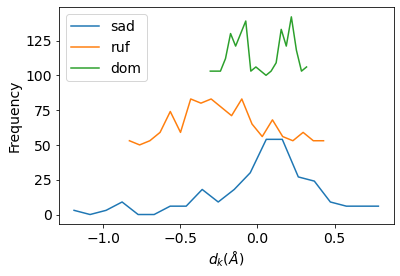

In [25]:
# import numpy as np
# import matplotlib.pyplot as plt
# plt.rcParams.update({'font.size': 14})

# nsd = np.loadtxt('data/exc/7FIX.exc/nsd.txt')
# names = ['sad', 'ruf', 'dom', 'wav(x)', 'wav(y)', 'prop']
# for n in range(0, 3):
#     hst,bins = np.histogram(nsd[:,n], 20)
#     plt.plot(bins[1:], hst+50*n, label=names[n])
# plt.legend()
# plt.ylabel('Frequency')
# plt.xlabel('$d_k (\\AA)$')
# plt.show()